# Script 14: Animando as Linhas de Corrente
Neste script vamos fzer o mesmo pot do script anterior, mas neste exemplo vamos gerar um GIF, animando as linhas de corrente, usando as funções encontradas no seguinte GitHub: https://github.com/rougier/windmap

Init: 2021-07-16 00:00:00 UTC
Run: 00Z
Forecast: +0
Valid: 2021-07-16 00:00:00 UTC



  0%|          | 0/30 [00:00<?, ?it/s]


Generating the GIF...


31it [01:50,  3.56s/it]                        



Opening the GIF...


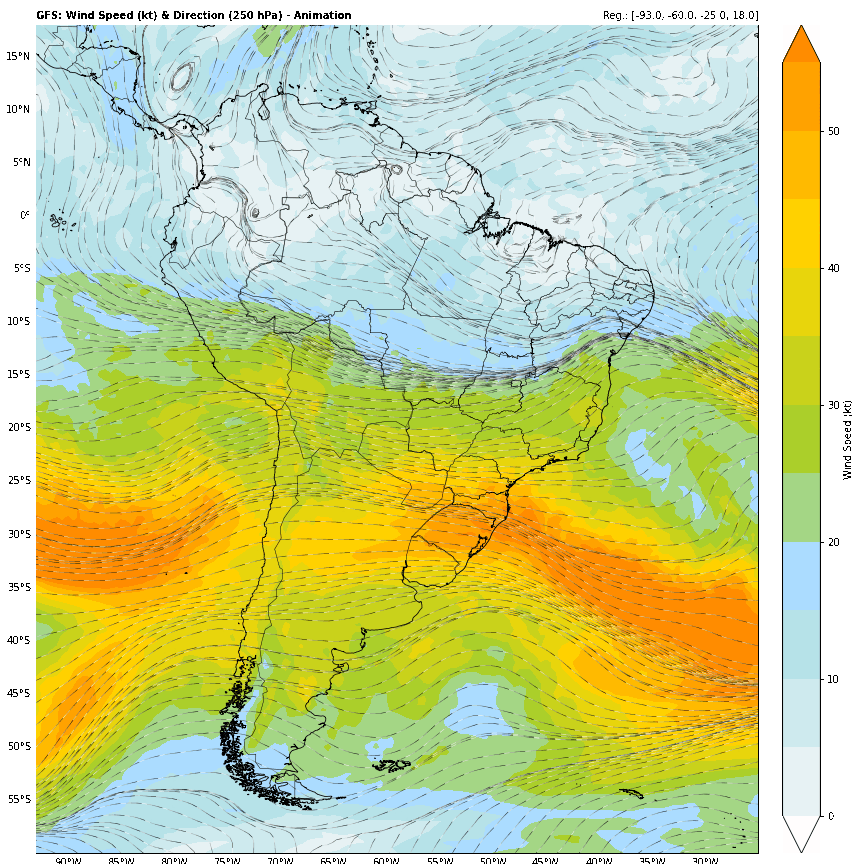

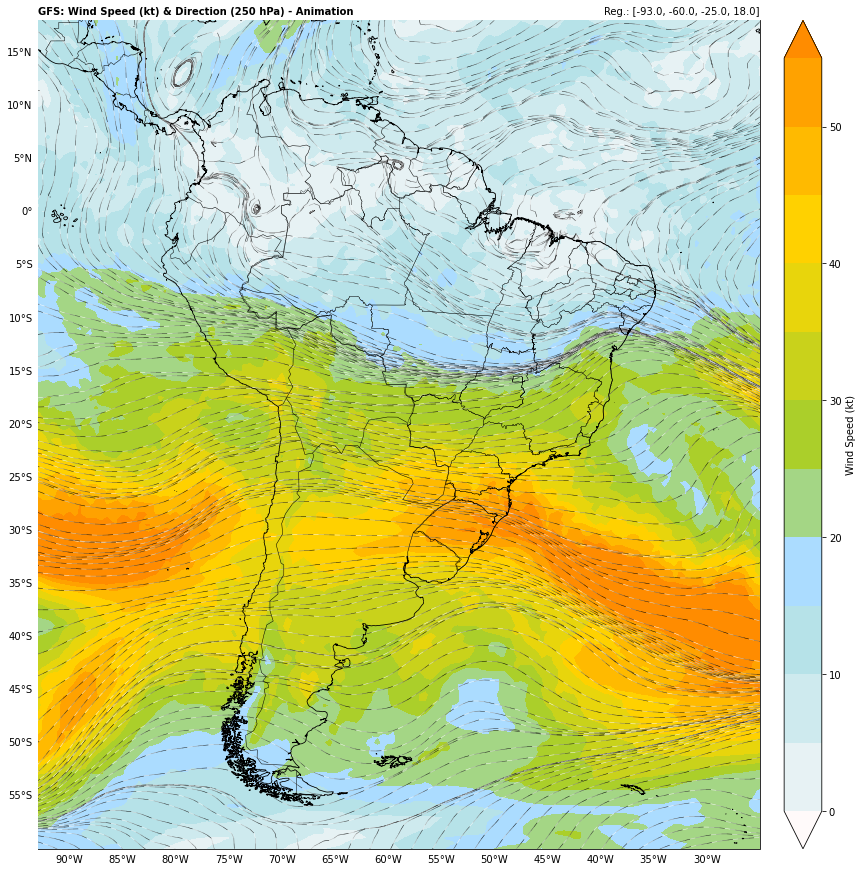

In [1]:
#-----------------------------------------------------------------------------------------------------------
# Curso INPE / CPTEC Training: NWP Data Processing With Python - Script 14: Animating Streamlines
# Instrutor: Diego Souza
# Adaptado: Dejanira F Braz
#-----------------------------------------------------------------------------------------------------------
import pygrib                                              # Provides a high-level interface to the ECWMF ECCODES C library for reading GRIB files
import matplotlib.pyplot as plt                            # Plotting library
import cartopy, cartopy.crs as ccrs                        # Plot maps
import cartopy.io.shapereader as shpreader                 # Import shapefiles
import numpy as np                                         # Scientific computing with Python
import matplotlib                                          # Comprehensive library for creating static, animated, and interactive visualizations in Python 
import tqdm                                                # A Fast, Extensible Progress Bar for Python and CLI
from matplotlib.animation import FuncAnimation, writers    # The easiest way to make a live animation in matplotlib 
from matplotlib.collections import LineCollection          # Allows one to plot multiple lines on a figure
#-----------------------------------------------------------------------------------------------------------

class Streamlines(object):
    """
    Copyright (c) 2011 Raymond Speth.
    Permission is hereby granted, free of charge, to any person obtaining a
    copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, sublicense,
    and/or sell copies of the Software, and to permit persons to whom the
    Software is furnished to do so, subject to the following conditions:
    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
    FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
    DEALINGS IN THE SOFTWARE.
    See: http://web.mit.edu/speth/Public/streamlines.py
    """

    def __init__(self, X, Y, U, V, res=1.00,
                 spacing=4, maxLen=1000, detectLoops=False):
        """
        Compute a set of streamlines covering the given velocity field.
        X and Y - 1D or 2D (e.g. generated by np.meshgrid) arrays of the
                  grid points. The mesh spacing is assumed to be uniform
                  in each dimension.
        U and V - 2D arrays of the velocity field.
        res - Sets the distance between successive points in each
              streamline (same units as X and Y)
        spacing - Sets the minimum density of streamlines, in grid points.
        maxLen - The maximum length of an individual streamline segment.
        detectLoops - Determines whether an attempt is made to stop extending
                      a given streamline before reaching maxLen points if
                      it forms a closed loop or reaches a velocity node.
        Plots are generated with the 'plot' or 'plotArrows' methods.
        """

        self.spacing = spacing
        self.detectLoops = detectLoops
        self.maxLen = maxLen
        self.res = res

        xa = np.asanyarray(X)
        ya = np.asanyarray(Y)
        self.x = xa if xa.ndim == 1 else xa[0]
        self.y = ya if ya.ndim == 1 else ya[:,0]
        self.u = U
        self.v = V
        self.dx = (self.x[-1]-self.x[0])/(self.x.size-1) # assume a regular grid
        self.dy = (self.y[-1]-self.y[0])/(self.y.size-1) # assume a regular grid
        self.dr = self.res * np.sqrt(self.dx * self.dy)

        # marker for which regions have contours
        self.used = np.zeros(self.u.shape, dtype=bool)
        self.used[0] = True
        self.used[-1] = True
        self.used[:,0] = True
        self.used[:,-1] = True

        # Don't try to compute streamlines in regions where there is no velocity data
        for i in range(self.x.size):
            for j in range(self.y.size):
                if self.u[j,i] == 0.0 and self.v[j,i] == 0.0:
                    self.used[j,i] = True

        # Make the streamlines
        self.streamlines = []
        while not self.used.all():
            nz = np.transpose(np.logical_not(self.used).nonzero())
            # Make a streamline starting at the first unrepresented grid point
            self.streamlines.append(self._makeStreamline(self.x[nz[0][1]],
                                                         self.y[nz[0][0]]))


    def _interp(self, x, y):
        """ Compute the velocity at point (x,y) """
        i = (x-self.x[0])/self.dx
        ai = i % 1

        j = (y-self.y[0])/self.dy
        aj = j % 1

        i, j = int(i), int(j)
        
        # Bilinear interpolation
        u = (self.u[j,i]*(1-ai)*(1-aj) +
             self.u[j,i+1]*ai*(1-aj) +
             self.u[j+1,i]*(1-ai)*aj +
             self.u[j+1,i+1]*ai*aj)

        v = (self.v[j,i]*(1-ai)*(1-aj) +
             self.v[j,i+1]*ai*(1-aj) +
             self.v[j+1,i]*(1-ai)*aj +
             self.v[j+1,i+1]*ai*aj)

        self.used[j:j+self.spacing,i:i+self.spacing] = True

        return u,v

    def _makeStreamline(self, x0, y0):
        """
        Compute a streamline extending in both directions from the given point.
        """

        sx, sy = self._makeHalfStreamline(x0, y0, 1) # forwards
        rx, ry = self._makeHalfStreamline(x0, y0, -1) # backwards

        rx.reverse()
        ry.reverse()

        return rx+[x0]+sx, ry+[y0]+sy

    def _makeHalfStreamline(self, x0, y0, sign):
        """
        Compute a streamline extending in one direction from the given point.
        """

        xmin = self.x[0]
        xmax = self.x[-1]
        ymin = self.y[0]
        ymax = self.y[-1]

        sx = []
        sy = []

        x = x0
        y = y0
        i = 0
        while xmin < x < xmax and ymin < y < ymax:
            u, v = self._interp(x, y)
            theta = np.arctan2(v,u)

            x += sign * self.dr * np.cos(theta)
            y += sign * self.dr * np.sin(theta)
            sx.append(x)
            sy.append(y)

            i += 1

            if self.detectLoops and i % 10 == 0 and self._detectLoop(sx, sy):
                break

            if i > self.maxLen / 2:
                break

        return sx, sy

    def _detectLoop(self, xVals, yVals):
        """ Detect closed loops and nodes in a streamline. """
        x = xVals[-1]
        y = yVals[-1]
        D = np.array([np.hypot(x-xj, y-yj)
                      for xj,yj in zip(xVals[:-1],yVals[:-1])])
        return (D < 0.9 * self.dr).any()

def update(frame_no):
    for i in range(len(lines)):
        lengths[i] += 0.05
        colors[i][:] = ((lengths[i]*1.5) % 1) 
        lines[i].set_color(colors[i])
    pbar.update()

#-----------------------------------------------------------------------------------------------------------

# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-93.0, -60.00, -25.00, 18.00]

# Open the GRIB file
grib = pygrib.open("Samples/gfs.t00z.pgrb2.0p50.f000")

#-----------------------------------------------------------------------------------------------------------

# Select the variable
ucomp = grib.select(name='U component of wind', typeOfLevel = 'isobaricInhPa', level = 200)[0]

# Get information from the file    
init  = str(ucomp.analDate)      # Init date / time
run   = str(ucomp.hour).zfill(2) # Run
ftime = str(ucomp.forecastTime)  # Forecast hour
valid = str(ucomp.validDate)     # Valid date / time 
print('Init: ' + init + ' UTC')
print('Run: ' + run + 'Z')
print('Forecast: +' + ftime)
print('Valid: ' + valid + ' UTC')

# Read the data for a specific region
ucomp, lats, lons = ucomp.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

#-----------------------------------------------------------------------------------------------------------

# Select the variable
vcomp = grib.select(name='V component of wind', typeOfLevel = 'isobaricInhPa', level = 250)[0]

# Read the data for a specific region
vcomp = vcomp.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)[0]

#-----------------------------------------------------------------------------------------------------------

# Calculate the wind speed
ws = np.sqrt(ucomp**2 + vcomp**2)

# Correct the longitudes from 0 - 360 
lons_corr = lons - 360

# Calculate the components
Y, X = lats, lons_corr
U, V = ucomp, vcomp 
speed = ws

#-----------------------------------------------------------------------------------------------------------

# Choose the plot size (width x height, in inches)
fig = plt.figure(figsize=(12,12))

# Use the Cilindrical Equidistant projection in cartopy
ax = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define de contour interval
data_min = 0
data_max = 60 
interval = 5
levels = np.arange(data_min,data_max,interval)

# Create a custom color palette 
colors = ["#e7f2f4", "#ceeaee", "#b6e2e8", "#abdcff", "#a4d685", "#9cd04e", 
          "#abcf2a", "#c9d21b", "#e8d50c", "#ffd100", "#ffba00", "#ffa200"]
cmap = matplotlib.colors.ListedColormap(colors)
cmap.set_over('#ff8c00')
cmap.set_under('#fffafa')

# Plot the contours
img1 = ax.contourf(lons, lats, ws, cmap=cmap, levels=levels, extend='both', alpha=1.0, zorder = 10) 

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('Shapefile/BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=14)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=0.8, zorder=15)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5, zorder=16)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.50, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
plt.colorbar(img1, label='Wind Speed (kt)', orientation='vertical', pad=0.03, fraction=0.05)

# Add a title
plt.title('GFS: Wind Speed (kt) & Direction (250 hPa) - Animation', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')

#-----------------------------------------------------------------------------------------------------------

lengths = []
colors = []
lines = []
s = Streamlines(X, Y, U, V)

for streamline in s.streamlines:
    
    x, y = streamline
    
    # Points
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    
    # Segments
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)
    
    # Lenghts
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n,1) + np.random.uniform(0,1)
    
    # Colors
    C = np.zeros((n,3))
    C[:] = ((L*1.5) % 1) 

    # Lines
    line = LineCollection(segments, linewidth=0.5, zorder=13)
   
    # Append lenghts, colors and lines
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    ax.add_collection(line)

# Plot extent
ax.set_xlim(extent[0],extent[2]), ax.set_xticks([])
ax.set_ylim(extent[1],extent[3]), ax.set_yticks([])
plt.tight_layout()

#-----------------------------------------------------------------------------------------------------------

# Number of frames
n = 30

# Create the animation
animation = FuncAnimation(fig, update, frames=n, interval=20)

# Update the progress bar
pbar = tqdm.tqdm(total=n)

# Save animation as GIF
print("\nGenerating the GIF...")
animation.save('Figure/wind.gif', writer='imagemagick', fps=30)

# Close the progress bar
pbar.close()

# Open the GIF
print("\nOpening the GIF...")
from IPython.display import Image
Image(open('Figure/wind.gif','rb').read())